In [29]:
import numpy as np
import pandas as pd
import imp
import os
import tensorflow as tf

from matplotlib import pyplot as plt

import data
import util

imp.reload(data)
imp.reload(util)

<module 'util' from 'C:\\Users\\graham\\classes\\ds_exp\\ds-project\\src\\util.py'>

In [30]:
from IPython.display import Audio, display

url_exception = "http://www.wav-sounds.com/movie/austinpowers.wav"
url_exception = "https://www.myinstants.com/media/sounds/roblox-death-sound_1.mp3"


def play_sound(self, etype, value, tb, tb_offset=None):
    self.showtraceback((etype, value, tb), tb_offset=tb_offset)
    display(Audio(url=url_exception, autoplay=True))


get_ipython().set_custom_exc((Exception,), play_sound)

In [31]:
data_dir = os.path.join(os.getcwd(), "..", "data")
mega_file = os.path.join(data_dir, "mega_stop_event_1.hdf")
df = pd.read_hdf(mega_file, "/df", stop=100000)
# df = pd.read_hdf(mega_file, "/df", stop=1000000)
# df = pd.read_hdf(mega_file, "/df")

In [32]:
print("shape:", df.shape)
df = df.drop_duplicates()
print("shape:", df.shape)

shape: (100000, 32)
shape: (100000, 32)


In [33]:
# util.big_print(df[['trip_number', 'stop_time']].head(1000))

In [34]:
# df = df.sort_values(["service_date", "direction", "train", "trip_number", "stop_time"])
df = df.sort_values(["service_date", "train", "trip_number", "stop_time"])

In [35]:
df["label"] = df.groupby(["service_date", "train", "trip_number"])[
    "arrival_deviance"
].shift(-1)
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [36]:
df = df.reset_index(drop=True)

In [37]:
print("shape:", df.shape)
df = df.drop_duplicates()
print("shape:", df.shape)

shape: (99043, 33)
shape: (99043, 33)


## how do we really want to structure this data?

* we want to make things somehow discrete by their trip_id
* so we want to somehow take the trip id and feed the model things about the trip
* we would feed it about the trip (up to different levels, and also expect it to answer about the whole trip each time
* yes so make a multi output thing that takes in a variable amount of information about the trip and answers about either - what it hasnt been supplied yet
* we want to have it somehow take in the previous x stops, and predict the next x stops?
* we dont want to punish it for guessing outside of the trip either
* we could also have it take in the last data to predict the stops
* start with only feeding it nothing besides day of the week and stuff, have it predict the times on the route
* slowly add in the realtime stats as the bus goes through its route, feeding it more each time
* we could either have it feed in more and more until it's filled, or just use a 0 padded window of bus stops. 
* let's look more into how rnn's and lstm's are normally constructed.


In [38]:
# filter
df = df[
    [
        #         "apc_status",
        "arrival_deviance",
        "arrive_deviance_departure_delta",
        "arrive_time",
        #         "data_source",
        "day_of_week",
        "day_of_year",
        "direction",
        "door",
        "dwell",
        "estimated_load",
        "leave_time",
        "lift",
        "label",
        "location_id",
        "maximum_speed",
        "offs",
        "ons",
        "pattern_distance",
        "route_number",
        "schedule_status",
        #                 "service_date",
        "service_key",
        "stop_time",
        "time_cat_arrive_time",
        "time_cat_leave_time",
        "time_cat_stop_time",
        "train",
        "train_mileage",
        "trip_number",
        "vehicle_number",
        "x_coordinate",
        "y_coordinate",
    ]
]

0    10858.0
1     7605.0
2    13033.0
3    12862.0
4     9347.0
5     4558.0
6    12868.0
7    12863.0
8     4556.0
9     4553.0
Name: location_id, dtype: category
Categories (173, float64): [0.0, 2253.0, 3397.0, 3398.0, ..., 13792.0, 13825.0, 13957.0, 14018.0]


C:\tools\miniconda3\envs\tf\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


In [12]:
df = pd.get_dummies(df)  # turns all categoricals into one hot encoded columns!

In [13]:
print("shape:", df.shape)

shape: (99043, 1940)


In [14]:
df = df.astype("float32")

In [15]:
# shuffle
from numpy.random import default_rng


def shuffle_dfs_in_place(dfs):
    length = dfs[0].shape[0]
    for df in dfs:
        assert df.shape[0] == length
    rng = default_rng()
    idx = rng.choice(length, length)
    for i, df in enumerate(dfs):
        dfs[i] = df.iloc[idx]


def shuffle_dfs(a, b):
    assert a.shape[0] == b.shape[0]
    length = a.shape[0]
    x = a
    y = b
    rng = default_rng()
    idx = rng.choice(length, length)
    x = x.iloc[idx]
    y = y.iloc[idx]
    return x, y


# x_train, y_train = shuffle_dfs(x_train, y_train)

In [16]:
shuffle_dfs_in_place([df])

In [17]:
def train_val_test(train, val, test, df, target):
    assert train + val + test == 1
    data_len = len(df)
    train_size = int(train * data_len)
    val_size = int(val * data_len)

    x = []
    x.append(df.iloc[:train_size])
    x.append(df.iloc[train_size : train_size + val_size])
    x.append(df.iloc[train_size + val_size :])

    y = []
    for df in x:
        y.append(df.pop(target))

    return (*x, *y)


x_train, x_val, x_test, y_train, y_val, y_test = train_val_test(
    0.8, 0.1, 0.1, df, "label"
)

del df

In [18]:
# x = df
# label = x.pop("label")

In [19]:
# batch_size = 50
# data_len = len(x)
# train = 0.8
# val = 0.1
# test = 0.1

# assert train + val + test == 1

# train_size = int(train * data_len)
# val_size = int(val * data_len)

# dataset = tf.data.Dataset.from_tensor_slices((x.values, label.values))

# # only shuffles the training set
# train_dataset = dataset.take(train_size).shuffle(int(1e6)).batch(batch_size)
# val_dataset = dataset.skip(train_size).take(val_size).batch(batch_size)
# test_dataset = dataset.skip(train_size).skip(val_size).batch(batch_size)

In [20]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import Pipeline

# pipe = Pipeline([("scaler", MinMaxScaler()), ("pca", PCA(1000))])
# x_train = pipe.fit_transform(x_train)
# print("sum of variance_ratio: ", np.sum(pipe["pca"].explained_variance_ratio_))
# x_val = pipe.transform(x_val)
# x_test = pipe.transform(x_test)

In [21]:
tf.random.set_seed(1234)

In [22]:
def get_compiled_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1000, activation="relu"),
            tf.keras.layers.Dense(500, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dense(50, activation="relu"),
            #             tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1),
        ]
    )

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.MeanSquaredError(
            reduction="auto", name="mean_squared_error"
        ),
        metrics=["accuracy", "mean_absolute_error"],
    )

    return model

In [23]:
model = get_compiled_model()
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_absolute_error", patience=10, restore_best_weights=True
)
model.fit(
    x=x_train,
    y=y_train,
    #     train_dataset,
    batch_size=64,
    epochs=100,
    validation_data=(x_val, y_val),
    #     validation_data=val_dataset,
    callbacks=[callback],
)

Epoch 1/100
793/793 [==============================] - 8s 8ms/step - loss: 45784.1016 - accuracy: 0.0044 - mean_absolute_error: 51.0985 - val_loss: 25322.1816 - val_accuracy: 0.0063 - val_mean_absolute_error: 119.5579
Epoch 2/100
793/793 [==============================] - 6s 7ms/step - loss: 42039.8828 - accuracy: 0.0044 - mean_absolute_error: 40.6056 - val_loss: 22420.2578 - val_accuracy: 0.0056 - val_mean_absolute_error: 121.7142
Epoch 3/100
793/793 [==============================] - 6s 7ms/step - loss: 41732.0117 - accuracy: 0.0044 - mean_absolute_error: 38.9242 - val_loss: 11994.6270 - val_accuracy: 0.0050 - val_mean_absolute_error: 83.6317
Epoch 4/100
793/793 [==============================] - 6s 7ms/step - loss: 41618.0273 - accuracy: 0.0043 - mean_absolute_error: 38.9430 - val_loss: 33563.8867 - val_accuracy: 0.0047 - val_mean_absolute_error: 157.8815
Epoch 5/100
793/793 [==============================] - 6s 7ms/step - loss: 41104.2695 - accuracy: 0.0040 - mean_absolute_error: 3

In [24]:
model.evaluate(x=x_test, y=y_test)
# model.evaluate(test_dataset)

310/310 [==============================] - 1s 3ms/step - loss: 535284.6250 - accuracy: 0.0054 - mean_absolute_error: 121.6284


[535284.625, 0.00535083282738924, 121.6283950805664]

In [25]:
# util.big_print(y_test.head(100))

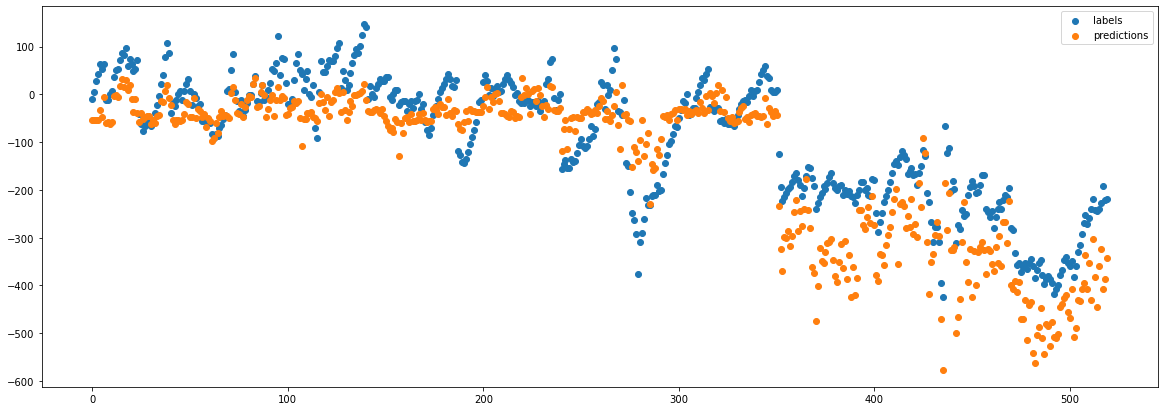

In [26]:
preds = model.predict(x=x_test)
util.plot(200, 720, preds, y_test)
util.allDone()

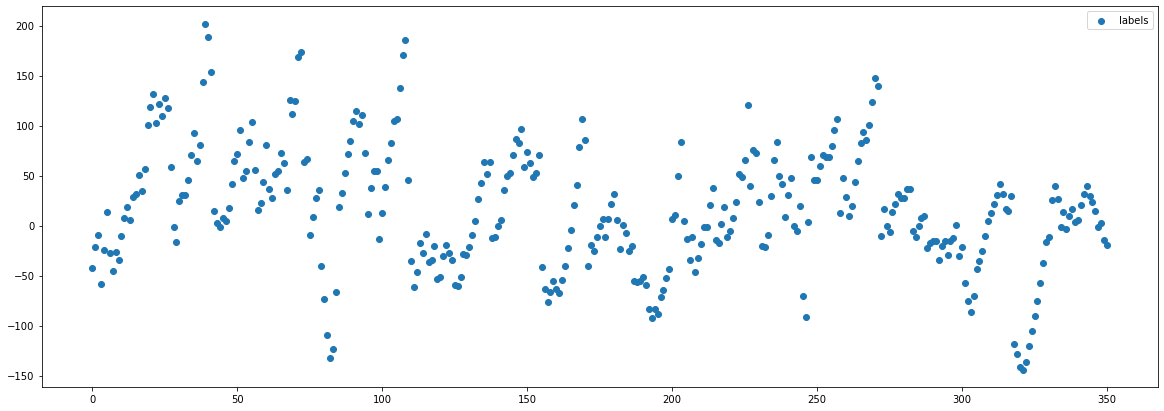

In [27]:
def plot(l, r, labels, width=20, height=7):
    labels = labels[l:r]
    x = list(range(len(labels)))
    plt.rcParams["figure.figsize"] = [width, height]
    plt.scatter(x, labels, label="labels")
    plt.legend()
    plt.show()


plot(69, 420, y_test)